## Assignment 5

# Tracking of a moving object which trajectory is disturbed by random acceleration

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of Assignment 5 is to develop standard Kalman filter for tracking a moving object which trajectory is disturbed by random acceleration. Important outcome of this exercise is getting deeper understanding of Kalman filter parameters and their role in estimation. Students will analyze the sensitivity of estimations to choice of non-optimal parameters and dependence on initial conditions.**

In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

**Firstly, we generate a true trajectory $x_i$ of an object motion disturbed by normally distributed random acceleration:**

In [3]:
def motion(initialX,initialV,initialT,noiseSigma,size):
    x = [initialX]
    v  = [initialV]
    acceleration = 0
    for i in range(1,size):
        x.append(x[i - 1] + v[i - 1]*initialT + acceleration*initialT**2/2)
        acceleration = np.random.normal(0, noiseSigma)
        v.append(v[i - 1] + acceleration * initialT)
    return x,v

In [4]:
# Initial conditions, variance of noise, size of trajectory

initialX_1 = 5
initialV_1 = 1
initialT_1 = 1
internalNoiseSigma_1 = 0.2
size_1 = 200
measSigma_2 = 20

**Then, we generate measurements $z_i$ of the coordinate $x_i$, but this time we don't have a measurement for every time step - there are some gaps with appear with specified probability:**

In [5]:
def measurements(process,mean,sigma):
    arr = process.copy()
    for i in range(0,len(arr)):
        arr[i] = arr[i] + np.random.normal(mean,sigma)
    return arr

In [6]:
# Define a function for plotting

def showPlease(arr,legend,xlabel,ylabel,title):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

**In order to present the system at state space, we define a period T and introduce F - transition matrix that relates $X_i$ and $X_{i-1}$, G - input matrix that determines how random acceleration $a_i$ affects state vector, H - observation matrix:**

In [7]:
T = 1
F = np.matrix([[1,T],
             [0,1]])
G = np.matrix([[T**2/2],
                 [T]])
H = np.matrix([[1,0]])

**The following functions help us develop Kalman filter algorithm.**

In [8]:
# Function which takes a vector as input and returns dafa from a specified axis

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

In [9]:
# Function which takes two processes as input and returns their combination as a vector

def giveVectors(processX,processV):
    X = []
    lastIndexX = len(processX) - 1
    lastIndexV = len(processV) - 1
    for i in range(0,max(lastIndexX + 1,lastIndexV + 1)):
        x = [[],[]]
        if(lastIndexX < i):
            x[0].append(0)
        else:
            x[0].append(processX[i])
        if(lastIndexV < i):
            x[1].append(0)
        else:
            x[1].append(processV[i])
        X.append(np.matrix((x)))
    return X

**Now, we develop Kalman filter algorithm to estimate state vector $X_i$ (extrapolation and filtration) with given initial filtered estimate X_0 and initial filtration error covariance matrix P_0. To calculate covariance matrix Q of state noise and covariance matrix R of measurements noise, we used hints provided in the assignment. The algorithm is as follows:**

In [10]:
# Initial filtred estimate and initial filtration error covariance matrix

initialKalmanX_3 = np.matrix([[2],
                    [0]])
initialP_3 = np.matrix([[10000,0],
                    [0,10000]])

In [11]:
# The algorithm itself

class KalmanFilter:
    
    def __init__(self,initialX,initialP,measStates,trueTrajectory,typeofProcess,noiseSigma,vectorK,H,
                F,measSigma,G):
        self.trueTrajectory = trueTrajectory.copy()
        self.measTrajectory = giveElements(measStates,0)
        self.kalmanStates = []
        self.listP = []
        self.listK = []
        
        self.measSigma = measSigma
        self.R = self.giveR()
        self.F = F
        self.H = H
        self.G = G
        prevX = initialX.copy()
        prevP = initialP.copy()
        if(len(vectorK)):
            K = vectorK
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        else:
            for i in range(0,len(measStates)):
                predictedX,predictedP = self.predict(prevX,prevP,self.giveF(i,i - 1),self.giveQ(i,typeofProcess,noiseSigma))
                K = self.giveK(predictedP,self.giveH(i),self.R)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,measStates[i][0],self.giveH(i),self.R)
                self.listP.append(prevP)
                self.kalmanStates.append(prevX)
                self.listK.append(K)
        self.kalmanTrajectory = giveElements(self.kalmanStates,0)
        
    def giveK(self):
        return self.listK.copy()
    
    def extrapolate(self,step):
        predictions = []
        for i in range(step-1,len(self.trueTrajectory)):
            predictions.append((self.giveF(i,i - 1)**(step - 1))*self.kalmanStates[i - step + 1])
        return predictions
    
    def errors(self,listValues):
        start = 0
        errors = []
        if(len(listValues) < len(self.trueTrajectory)):
            start = len(self.trueTrajectory) - len(listValues)
        for i in range(start,len(self.trueTrajectory)):
            errors.append(self.trueTrajectory[i] - listValues[i - start ])
        return errors
    
    def giveQ(self,index,typeOfProcess,noiseSigma):
        G = self.G
        if(typeOfProcess == "det"):
            return 0
        else:
            return G*G.T*(noiseSigma**2)
        
    def giveK(self,predictedP,H,R):
        return predictedP*H.T*(H*predictedP*H.T + R)**(-1)
    
    def giveR(self):
        return self.measSigma**2
    
    def giveH(self,index):
        return self.H
    
    def giveF(self,firstIndex,secondIndex):
        return self.F
    
    def predict(self,prevX,prevP,F,Q):
        x = F*prevX
        P = F*prevP*F.T + Q
        return x,P
    
    def filtrate(self,predictedX,predictedP,K,meas,H,R):
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def givePError(self):
        p = []
        for i in self.listP:
            p.append((i.item(0,0))**0.5)
        return p

In [12]:
# Define a function which runs the algorithm

def createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G):
    processX,processV = motion(initialX,initialV,initialT,noiseSigma,size)
    meas = measurements(processX,0,measSigma)
    states = giveVectors(meas,[])
    return KalmanFilter(initialKalmanX,initialP,states,processX,typeOfProcess,noiseSigma,vectorK,H,F,measSigma,G)

**As a result, we obtain filtred estimates using Kalman filter and then compare them with the true trajectory and measurements:**

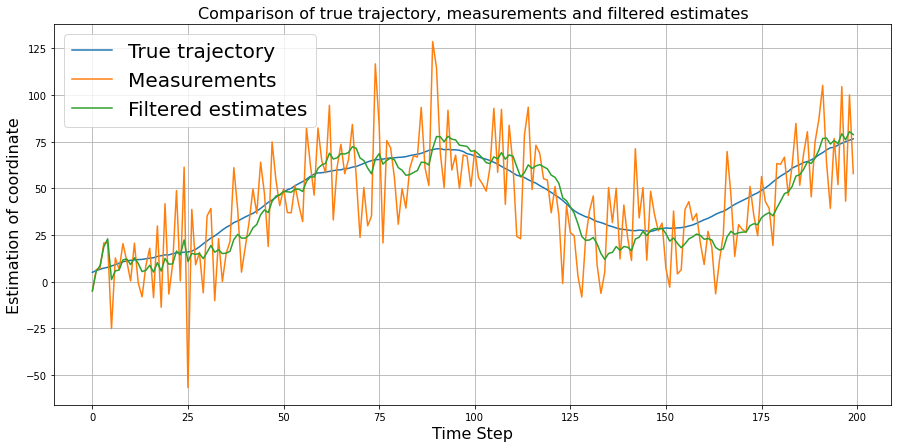

In [13]:
kalmanFilter_4 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                         initialKalmanX_3,initialP_3,"usual",[],H,F,G)

showPlease([kalmanFilter_4.trueTrajectory,kalmanFilter_4.measTrajectory,kalmanFilter_4.kalmanTrajectory],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Estimation of coordinate',
            'Comparison of true trajectory, measurements and filtered estimates')

**One more trajectory to compare the results:**

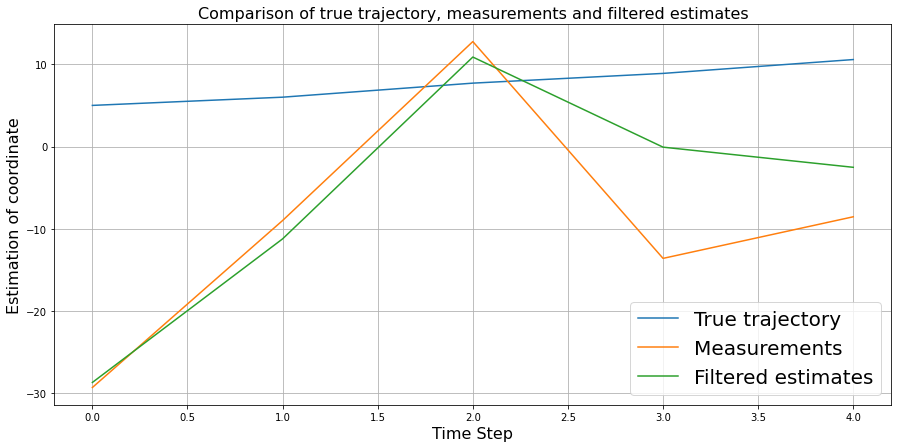

In [14]:
kalmanFilter_5 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                         initialKalmanX_3,initialP_3,"usual",[],H,F,G)

showPlease([kalmanFilter_5.trueTrajectory[0:5],kalmanFilter_5.measTrajectory[0:5],kalmanFilter_5.kalmanTrajectory[0:5]],
           ["True trajectory","Measurements","Filtered estimates"], 'Time Step', 'Estimation of coordinate',
            'Comparison of true trajectory, measurements and filtered estimates')

**Depending on the true trajectory, or, more precisely, on the measurement noise, Kalman filter provides different estimation results with the most accurate one when the measurements are less noisy and vice versa.**

**In order to verify whether filter gain K and filtration error covariance matrix P become constant quickly, we plot the values of K and the values of standard deviation of coordinate $x_i$ estimation error over the whole filtration interval.**

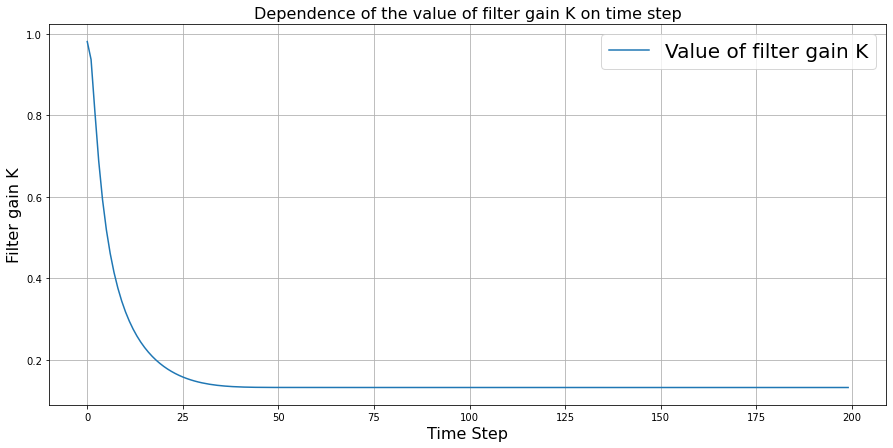

In [15]:
showPlease([giveElements(kalmanFilter_4.listK,0)], ['Value of filter gain K'],'Time Step', 'Filter gain K', 
            'Dependence of the value of filter gain K on time step')

**Filter gain K shows the weight of residual: the more the value of filter gain, the more the influence of measurements on the estimation, the less the value of K, the more the influence of predictions on the estimation. During the first 25 steps the value of K sharply decreases from almost 1 to less than 0.2, but then it becomes constant - it means that in conditions of a trajectory disturbed by random noise we cannot estimate more than established limit of accuracy due to uncertainty.**

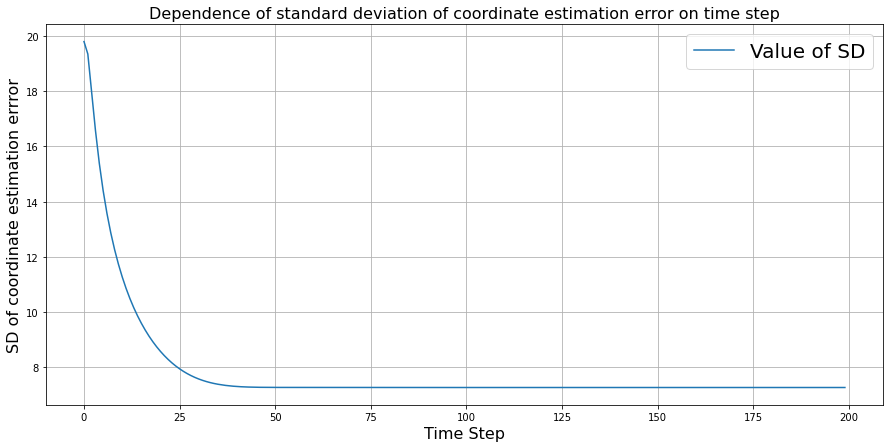

In [16]:
showPlease([kalmanFilter_4.givePError()],['Value of SD'], 'Time Step', 'SD of coordinate estimation errror', 
           'Dependence of standard deviation of coordinate estimation error on time step')

**During the filtration process, standard deviation of estimation error of coordinate $x_i$ rapidly drops within the first 25 steps likewise the filter gain K reaching a plateau - it proves again that in conditions of a trajectory disturbed by random noise it is impossible to estimate more than established limit of accuracy due to uncertainty.**

**Now we add to the code extrapolation on m = 7 steps ahead on every time step to estimate the ability of the filter to make predictions on m steps ahead (extrapolation code is already included in the class "Kalman Filter" above). In order to estimate dynamics of mean-squared error of estimation over observation interval, we calculate error for both filtered estimate of coordinate $x_{i,i}$ and its forecasting (extrapolation) 𝑚 steps ahead $x_{i+m-1, i}$ according to the plan provided in the assignment.**

In [17]:
def manyKalman(size,amount,initialX,initialV,initialT,noiseSigma,measSigma,
               initialKalmanX,initialP,predictStep,typeOfProcess,vectorK,H,F,G):
    filteredErrorsTotal = [0 for x in range(2,size)]
    predictedErrorsTotal = [0 for x in range(0,size - predictStep + 1)]
    for i in range(0,amount):
        kalman = createProcessGiveKalman(size,initialX,initialV,initialT,noiseSigma,
                            measSigma,initialKalmanX,initialP,typeOfProcess,vectorK,H,F,G)
        filteredErrors = kalman.errors(kalman.kalmanTrajectory)
        predictedErrors = kalman.errors(giveElements(kalman.extrapolate(predictStep),0))
        for j in range(2,size):
            filteredErrorsTotal[j - 2] = filteredErrorsTotal[j - 2] + filteredErrors[j]**2
        for j in range(0,size - predictStep + 1):
            predictedErrorsTotal[j] = predictedErrorsTotal[j] + predictedErrors[j]**2
    for i in range(0,len(filteredErrorsTotal)):
        filteredErrorsTotal[i] = (filteredErrorsTotal[i]/(amount - 1))**0.5
    for i in range(0,size - predictStep + 1):
        predictedErrorsTotal[i] = (predictedErrorsTotal[i]/(amount - 1))**0.5
    return filteredErrorsTotal, predictedErrorsTotal

In [18]:
initialStep_8 = 7

e_filtered_8,e_pred_8 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                   initialKalmanX_3,initialP_3,initialStep_8,"ususal",[],H,F,G)

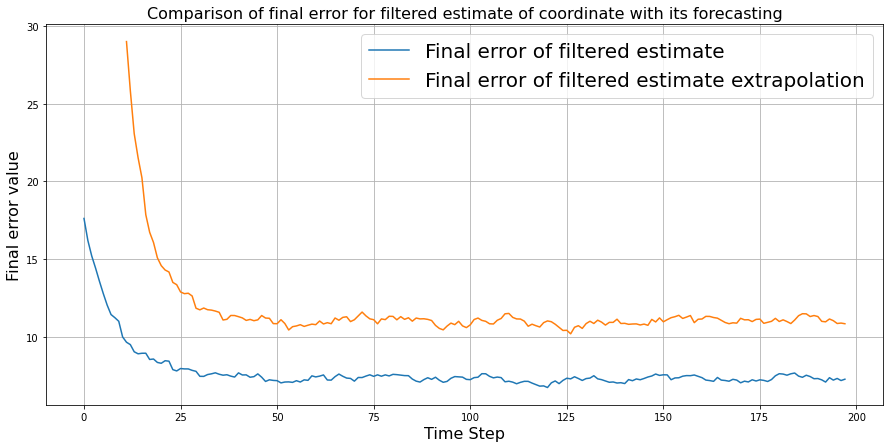

In [19]:
showPlease([e_filtered_8,e_pred_8[7:200]],['Final error of filtered estimate', 'Final error of filtered estimate extrapolation'], 
           'Time Step', 'Final error value', 
           'Comparison of final error for filtered estimate of coordinate with its forecasting');

**According to the plot, final error becomes almost constant after 25 steps so that estimation accuracy doesn't increase anymore after this point. Both final errors reach small values, although final error for extrapolation case is larger.**

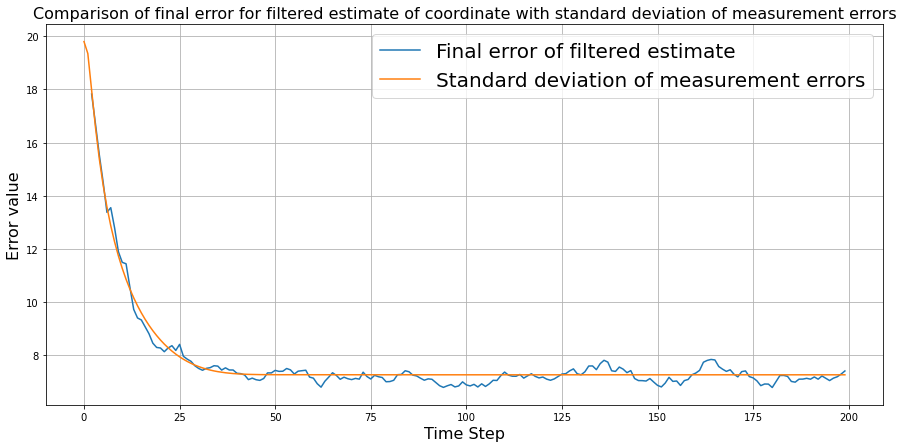

In [19]:
showPlease([e_filtered_8,kalmanFilter_4.givePError()],['Final error of filtered estimate', 
            'Standard deviation of measurement errors'], 
           'Time Step', 'Error value', 
           'Comparison of final error for filtered estimate of coordinate with standard deviation of measurement errors');

**Both lines have the same trend althought the one for mean-squared error has more fluctuations. Moreover, they achieve almost the same limit of accuracy due to uncertainty.**

**Now we use more accurate initial filtration error covariance matrix and calculate mean-squared error of filtered estimate of coordinate for this case:**

In [20]:
initialP_10 = np.matrix([[100,0],
                    [0,100]])

In [21]:
e_filtered_10,e_pred_10 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                     initialKalmanX_3,initialP_10,initialStep_8,"ususal",[],H,F,G)

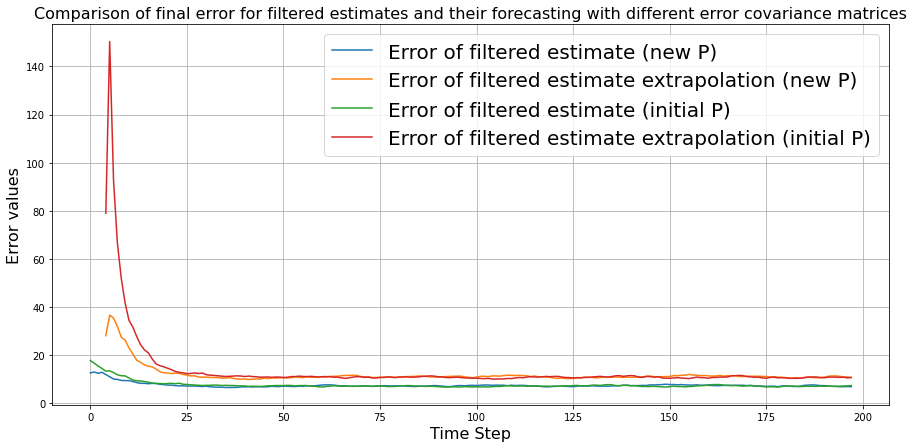

In [22]:
showPlease([e_filtered_10,e_pred_10,e_filtered_8,e_pred_8],['Error of filtered estimate (new P)', 
            'Error of filtered estimate extrapolation (new P)', 'Error of filtered estimate (initial P)', 
            'Error of filtered estimate extrapolation (initial P)'], 
            'Time Step', 'Error values', 
            'Comparison of final error for filtered estimates and their forecasting with different error covariance matrices')

**The graph shows that if initial conditions are more accurate, the final error of both filtered estimate and its extrapolation is lower.**

**Now we want to compare calculation errors of estimation 𝑃𝑖,𝑖 provided Kalman filter algorithm with true estimation errors:**

In [23]:
kalmanFilter_11v1 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                            initialKalmanX_3,initialP_3,"usual",[],H,F,G)

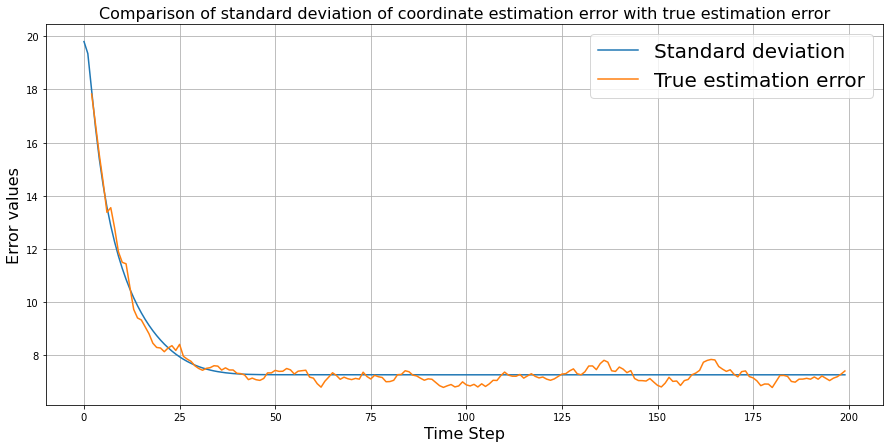

In [24]:
showPlease([kalmanFilter_11v1.givePError(),e_filtered_8],['Standard deviation', 
                                                          'True estimation error'], 'Time Step', 'Error values', 
           'Comparison of standard deviation of coordinate estimation error with true estimation error')

**Calculation errors of estimation indeed correspond to true estimation errors albeit the latter are more fluctuated.**

**Now we want to research how the filter operates with deterministic trajectory (no random disturbance). In this case, variance of state noise equals to zero.**

In [25]:
internalNoiseSigma_12 = 0

**In order to show that in case of motion without any random disturbances, the filter switches off from measurements, we need to verify that filter gain K, calculation errors and true estimation errors are rapidly approaching zero within the time interval under study:**

In [26]:
kalmanFilter_12 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_12,measSigma_2,
                                          initialKalmanX_3,initialP_3,"usual",[],H,F,G)

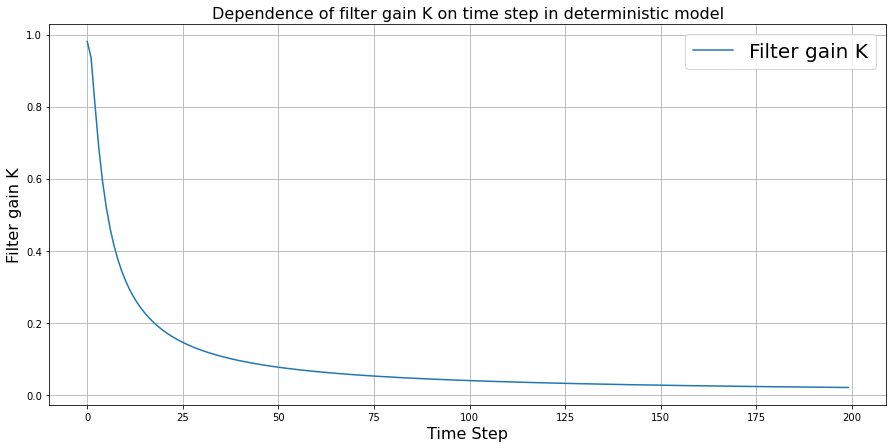

In [27]:
showPlease([giveElements(kalmanFilter_12.listK,0)],['Filter gain K'], 'Time Step', 'Filter gain K', 
           'Dependence of filter gain K on time step in deterministic model')

**The graph shows that the value of filter gain K drastically decreases within the first 25 steps approaching zero by the end of time interval.**

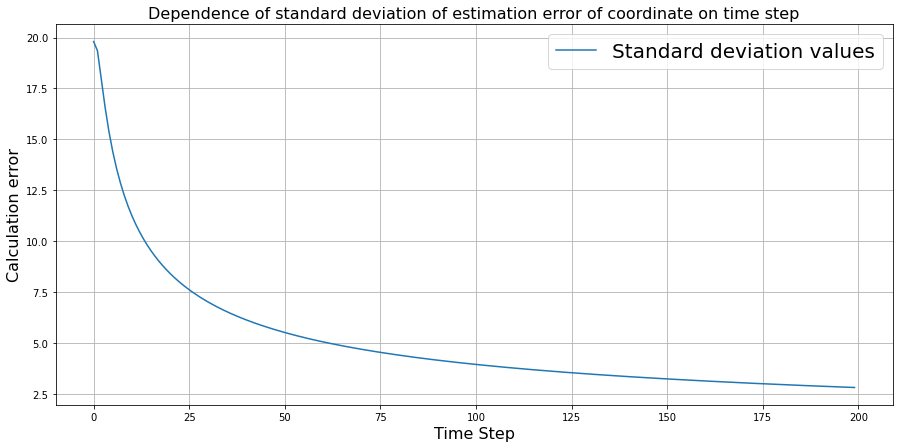

In [28]:
showPlease([kalmanFilter_12.givePError()],['Standard deviation values'], 'Time Step', 
           'Calculation error', 'Dependence of standard deviation of estimation error of coordinate on time step')

**The same trend is observed for standard deviation of estimation error of coordinate.**

In [29]:
e_filtered_12,e_pred_12 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_12,measSigma_2,
                                     initialKalmanX_3,initialP_10,initialStep_8,"ususal",[],H,F,G)

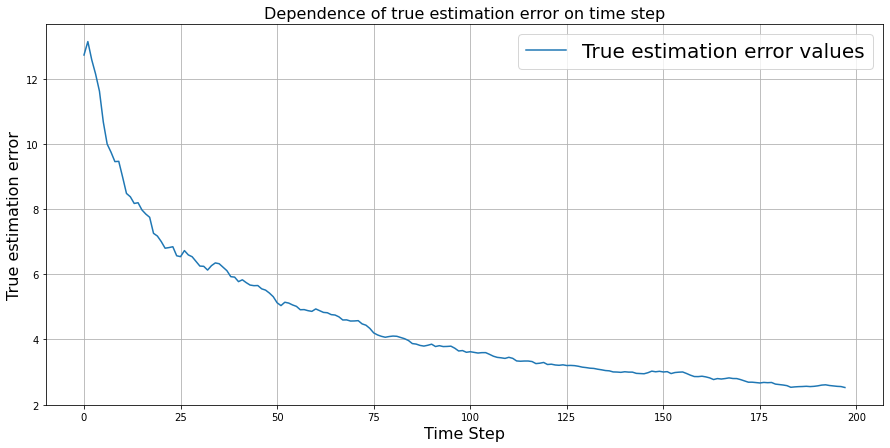

In [30]:
showPlease([e_filtered_12],['True estimation error values'], 'Time Step', 'True estimation error', 
           'Dependence of true estimation error on time step')

**True estimation error values gradually drop within the time period under study as well. Thus,  it is proved that in condition of motion without any random disturbances, filter switches off from measurements so that new measurements almost do not adjust estimates. This can be observed more clearly when plotting a graph of the deterministic trajectory and its filtered estimates:**

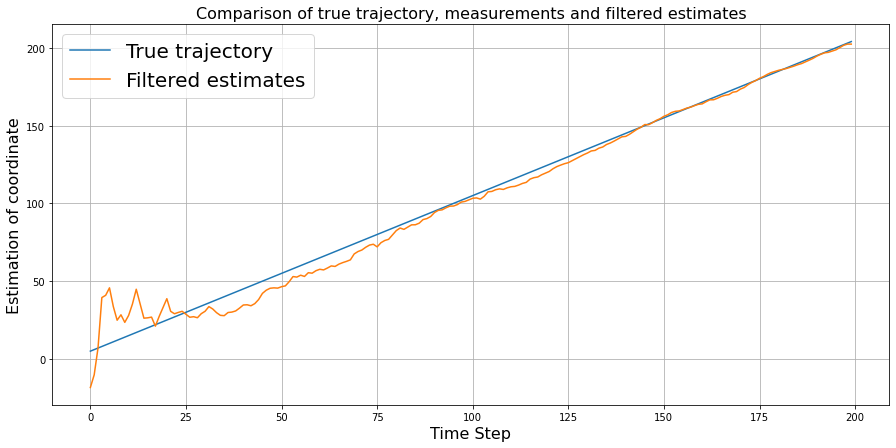

In [31]:
showPlease([kalmanFilter_12.trueTrajectory,kalmanFilter_12.kalmanTrajectory],['True trajectory', 'Filtered estimates'], 
           'Time Step', 'Estimation of coordinate', 'Comparison of true trajectory, measurements and filtered estimates')

**It takes a small period of time for filter to switch off from measurements (less than 25 time steps) and after that filtered estimates correctly describe true trajectory with some weak fluctuations.**

**Now we want to research how filter operates when we use deterministic model of motion, but in fact motion is disturbed
by random acceleration. For that, we use Q = 0 in Kalman filter algorithm.**


In [32]:
kalmanFilter_13 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                          initialKalmanX_3,initialP_3,"det",[],H,F,G)

In [33]:
e_filtered_13,e_pred_13 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                     initialKalmanX_3,initialP_10,initialStep_8,"det",[],H,F,G)

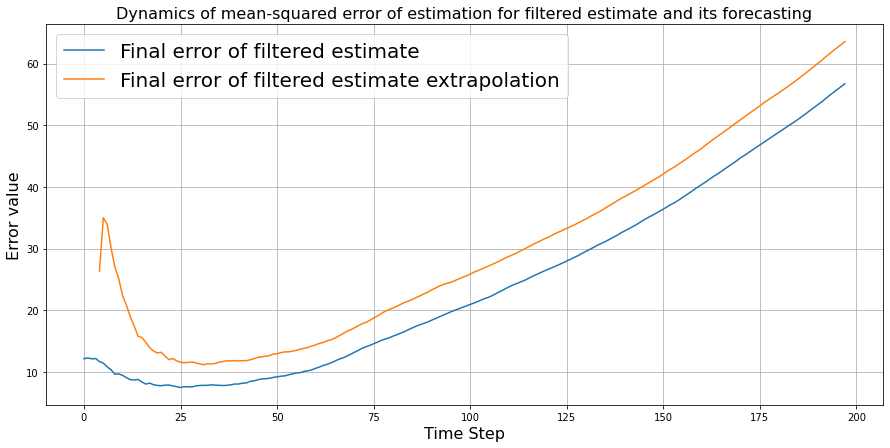

In [34]:
showPlease([e_filtered_13,e_pred_13],['Final error of filtered estimate', 'Final error of filtered estimate extrapolation'], 
           'Time Step', 'Error value', 
           'Dynamics of mean-squared error of estimation for filtered estimate and its forecasting')

**If we do not take into account state noise in Kalman filter algorithm in case when it takes place, the errors, both of filtered estimate and its forecasting, start rising in a dramatical way after approximately 25 steps. Therefore, it is crucial to use appropriate model of motion for each and every case in order to get correct filtration results.**

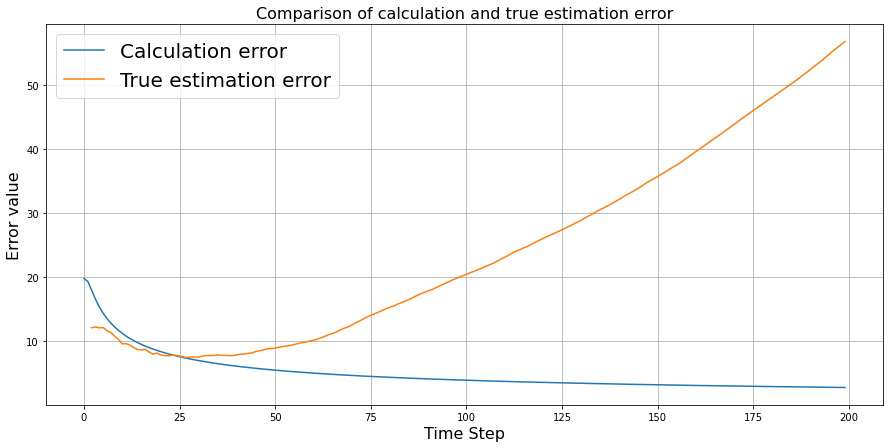

In [35]:
showPlease([kalmanFilter_13.givePError(),e_filtered_13],['Calculation error', 'True estimation error'], 
           'Time Step', 'Error value', 'Comparison of calculation and true estimation error')

**While calculation error experiences a drop, true estimation error is sharply rising. It means that neglecting state noise in Kalman filter algorithm in case where it exists may significantly reflect on estimation errors, while calculation errors do not depend on the model taken into consideration.**

**Now we want to analyze how the relationship between state and measurement noise affects time when filter gain become almost constant and estimation accuracy doesn’t increase anymore. In this case we compare the results obtained for different variance of state noise (1 and 0.04):**

In [36]:
internalNoiseSigma_14 = 1

In [37]:
kalmanFilter_14v1 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                            initialKalmanX_3,initialP_3,"usual",[],H,F,G)

In [38]:
kalmanFilter_14v2 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_14,measSigma_2,
                                            initialKalmanX_3,initialP_3,"usual",[],H,F,G)

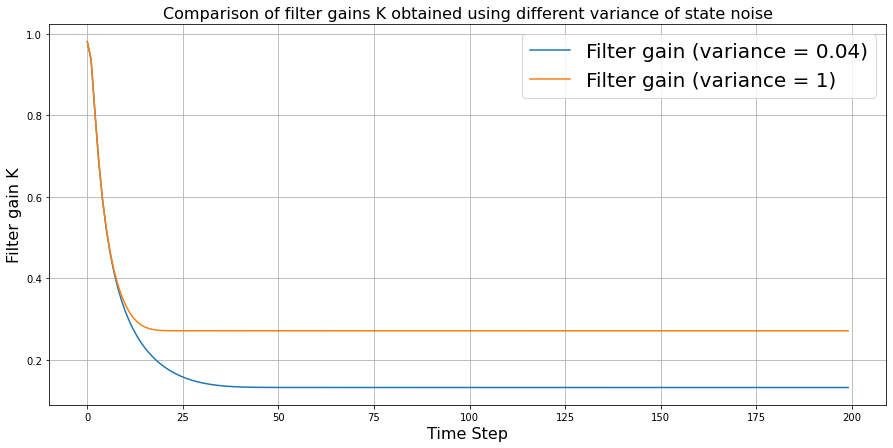

In [39]:
showPlease([giveElements(kalmanFilter_14v1.listK,0),giveElements(kalmanFilter_14v2.listK,0)],['Filter gain (variance = 0.04)',
            'Filter gain (variance = 1)'],'Time Step', 'Filter gain K', 
           'Comparison of filter gains K obtained using different variance of state noise')

**Filter gain K obtained for a smaller variance of state noise achieves plateau less rapidly than the one for with a variance of 1, although it reaches a lower value.**

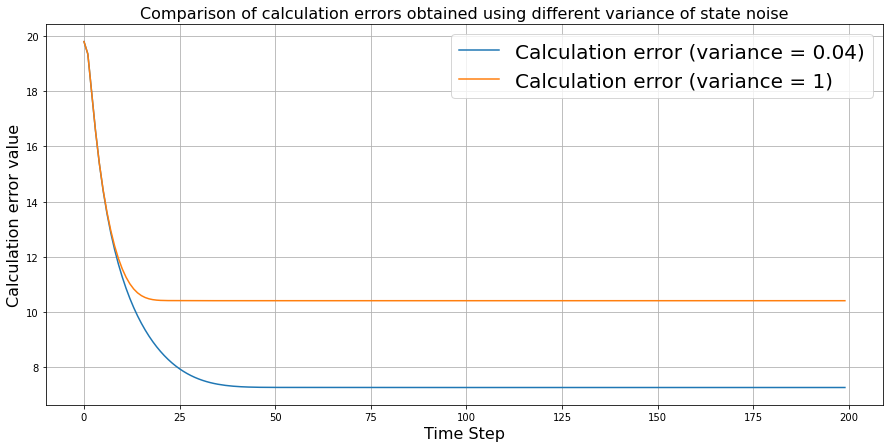

In [40]:
showPlease([kalmanFilter_14v1.givePError(),kalmanFilter_14v2.givePError()],['Calculation error (variance = 0.04)', 
            'Calculation error (variance = 1)'], 'Time Step', 'Calculation error value', 
           'Comparison of calculation errors obtained using different variance of state noise')

**The similar trend is observed for calculation errors - the less the variance, the slower the stabilized value of calculation errors is achieved (it takes about 50 time steps to achieve it) and vice versa.**

**Now we want to analyze sensitivity of filter to underestimated non-optimal filter gain K. In order to do that, we change initial filtered estimate:**

In [41]:
initialKalmanX_15 = np.matrix([[100],
                    [5]])
kalman_15 = createProcessGiveKalman(200,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,initialKalmanX_15,initialP_3,"usual",[],H,F,G)

**Then we take into account two conditions.**

**1) Firstly, we calculate optimal filter gain according to Kalman filter equations:**

In [42]:
optK = kalman_15.listK[len(kalman_15.listK) - 1]

**and mean-squared error of filtered estimate of coordinate $x_{i,i}$ for 500 runs:**

In [43]:
e_filtered_15,e_pred_15 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,
                                     initialKalmanX_15,initialP_3,initialStep_8,"ususal",[],H,F,G)

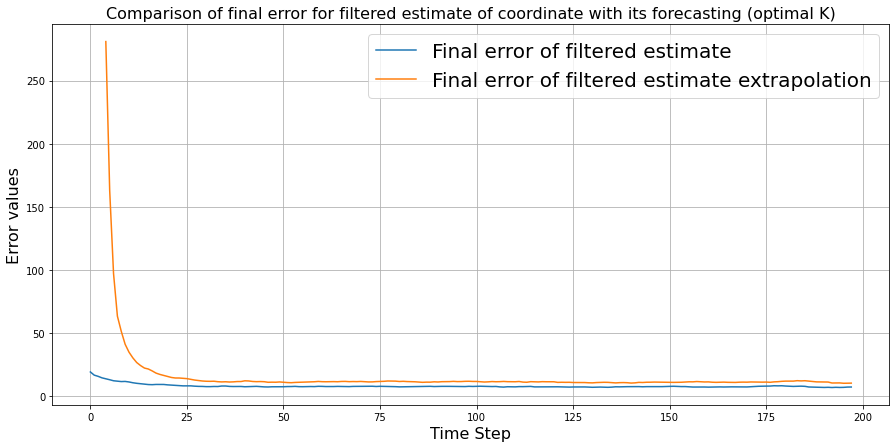

In [44]:
showPlease([e_filtered_15,e_pred_15],['Final error of filtered estimate', 'Final error of filtered estimate extrapolation'], 
           'Time Step', 'Error values', 'Comparison of final error for filtered estimate of coordinate with its forecasting (optimal K)')

**2) Secondly, we calculate underestimated non-optimal filter K by taking steady-state value of optimal filter gain divided by 5:**

In [45]:
underK = optK / 5

**and then calculate mean-squared error of filtered estimate of coordinate $x_{i,i}$ for in this conditions:**

In [46]:
e_filtered_15v2,e_pred_15v2 = manyKalman(200,500,initialX_1,initialV_1,initialT_1,internalNoiseSigma_1,measSigma_2,initialKalmanX_15,initialP_3,initialStep_8,"ususal",underK,H,F,G)

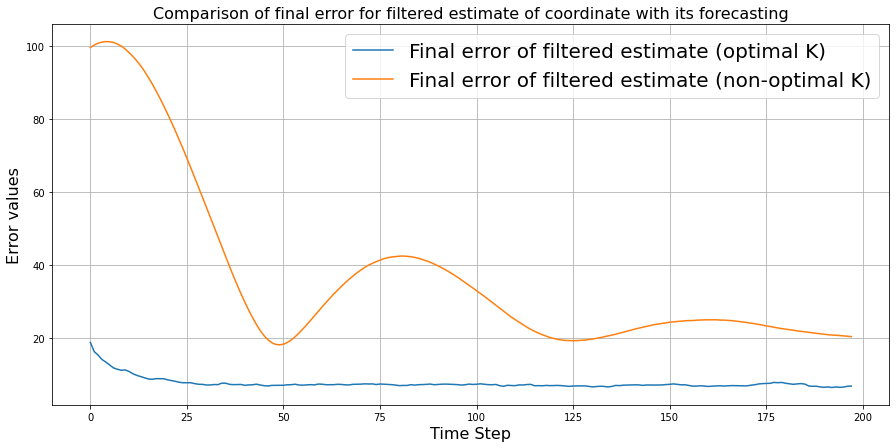

In [47]:
showPlease([e_filtered_15,e_filtered_15v2],['Final error of filtered estimate (optimal K)', 
                                            'Final error of filtered estimate (non-optimal K)'], 
           'Time Step', 'Error values', 'Comparison of final error for filtered estimate of coordinate with its forecasting')

**It is clearly seen from the graph that in case of underestimated filter gain, final error of filtered estimate is 5 times higher at the beginning of observational interval than the one in case of optimal K, then the error line experiences strong fluctuations resulting in appearance of local peaks, but after 125 time steps it becomes less senitive to the value of filter gain and by the end of the time period reaches plateau.**

**Conclusion: As it was the first assignment dedicated to standard Kalman filter, we faced a lot of problems regarding many question such as: how does the filter work? what results should we expect to get? how to code it? why are there so many tasks?The very first punch in the face happened when we tried to multiply matrices correctly using "@" — we kept obtaining the same wrong results (it was clear as the filter gain K took strange values which were growing and filtred estimates looked like not filtred at all) for at least two days but there was no doubt that the developed algorithm was written properly. Only after several dozens of attempts to rewrite the code, we realized that it was extremely important in Python to monitor the dimensions of the multiplied matrices and correct them using .reshape() function if needed — otherwise, the multiplication can go completely wrong. After that, we decided to code in a more detailed way and changed almost the whole approach to the assignment coding so that this mistake won't happen again as some Python functions seem to be like a "black box" - you never know for sure whether you obtain mathematically correct results or not after running the code. The next milestone appeared on the 8th task of the assignment — we were a little confused by the task statement: although the idea was clear, we weren't confident we understood how to make it step-by-step but again - it was just a matter of time (as it turned out - a matter of a quite long time period). 
Each and every task gave us many insight about how Kalman filter works, what are its drawbacks and what must be taken into account when working with it. Firstly, we saw what happens when we make extrapolation on M>1 steps ahead - at the beginning of observation period, final errors are much higher than the ones for extrapolation on just 1 step ahead, but later the values of these errors achieve plateau but on a higher level. It means that the accuracy level of Kalman filter algorithm tightly depends on the amount of steps ahead when making forecast - the lower the number of made steps ahead, the lower the limit level of accuracy of filtered estimates due to uncertainty. The filter is not able to forecast on many steps ahead without lossess from errors. Secondly, more accurate initial conditions lead to smaller values of final error which was kind of an obvious outcome. Thirdly, if calculation errors of estimation provided by Kalman filter algorithm correspond to true estimation errors, there should not be any doubts left in the efficiency of the filter. Moreover, when we consider deterministic model of motion without any random disturbances, estimation error rapidly approaches zero - it means that new measurements almost do not adjust estimates. BUT! If we do not take into account state noise in Kalman filter algorithm in case when it takes place, the errors start rising in a dramatical way resulting in a incorrect filtration. The less the variance of state noise, the slower the stabilized value of calculation errors is achieved  and vice versa. Kalman filter is sensitive to an underestimated non-optimal filter gain at the beginning of observation interval, but then after several fluctuations of final error, it stabilizes but on a higher level than in case of optimal filter gain. All in all, we got so many learnings that we need to process them again and again. But the most crusial learning of this assignment is "never ever think again that it is possible to solve the assignment, which was designed for a week preparation, in a shorter period of time".**